In [1]:
import seaborn           as sns
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import tensorflow        as tf
from   tensorflow                import keras
from   tensorflow.keras          import layers
from   sklearn.model_selection   import train_test_split
from   sklearn.feature_selection import SelectKBest
from   sklearn.feature_selection import chi2
from   keras.models              import Sequential
from   keras.layers              import Dense, Dropout
from   keras.optimizers          import SGD
from   keras.callbacks           import EarlyStopping

Using TensorFlow backend.


In [107]:
# Upload dataset
from google.colab import files
uploaded = files.upload()

In [0]:
# Load hours dataset
path = "./hour.csv"
dataset = pd.read_csv(path)

In [109]:
for i in dataset.columns.values:
  print(i, dataset[i].dtype)

instant int64
dteday object
season int64
yr int64
mnth int64
hr int64
holiday int64
weekday int64
workingday int64
weathersit int64
temp float64
atemp float64
hum float64
windspeed float64
casual int64
registered int64
cnt int64


In [110]:
dataset.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [0]:
def generate_dummies(df, dummy_column):
    dummies = pd.get_dummies(df[dummy_column], prefix=dummy_column)
    df = pd.concat([df, dummies], axis=1)
    return df

X = pd.DataFrame.copy(dataset)
dummy_columns = ["season",     # season (1:springer, 2:summer, 3:fall, 4:winter)
                 "mnth",        # month ( 1 to 12)
                 "hr",          # hour (0 to 23)
                 "weekday",     # weekday : day of the week
                 "weathersit"   # weathersit : 
                                 # - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                                 # - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                                 # - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                                 # - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
                ]
for dummy_column in dummy_columns:
    X = generate_dummies(X, dummy_column)

In [0]:
for dummy_column in dummy_columns:
  del X[dummy_column]

In [0]:
del X["yr"]
del X["hum"]
del X["instant"]
del X["dteday"]

y = X["cnt"]

del X["cnt"]
del X["registered"]
del X["casual"]

In [114]:
X.head()
print(X.columns.values)

['holiday' 'workingday' 'temp' 'atemp' 'windspeed' 'season_1' 'season_2'
 'season_3' 'season_4' 'mnth_1' 'mnth_2' 'mnth_3' 'mnth_4' 'mnth_5'
 'mnth_6' 'mnth_7' 'mnth_8' 'mnth_9' 'mnth_10' 'mnth_11' 'mnth_12' 'hr_0'
 'hr_1' 'hr_2' 'hr_3' 'hr_4' 'hr_5' 'hr_6' 'hr_7' 'hr_8' 'hr_9' 'hr_10'
 'hr_11' 'hr_12' 'hr_13' 'hr_14' 'hr_15' 'hr_16' 'hr_17' 'hr_18' 'hr_19'
 'hr_20' 'hr_21' 'hr_22' 'hr_23' 'weekday_0' 'weekday_1' 'weekday_2'
 'weekday_3' 'weekday_4' 'weekday_5' 'weekday_6' 'weathersit_1'
 'weathersit_2' 'weathersit_3' 'weathersit_4']


In [115]:
all_days = len(X) // 24
print("Total observations", len(X))
print("Total number of days", all_days)
days_for_training = int(all_days * 0.7)

X_train = X[0:days_for_training]
X_test = X[days_for_training:]

y_train = y[0:days_for_training]
y_test= y[days_for_training:]

Total observations 17379
Total number of days 724


In [116]:
print("Observations for training", len(X_train))
print("Observations for testing", len(X_test))
print("Some target values", y.head())

Observations for training 506
Observations for testing 16873
Some target values 0    16
1    40
2    32
3    13
4     1
Name: cnt, dtype: int64


In [125]:
print("Sum of X_train columns: ", len(X_train.columns.values))
print("Columns of X_train: \n", X_train.columns.values)

Sum of X_train columns:  56
Columns of X_train: 
 ['holiday' 'workingday' 'temp' 'atemp' 'windspeed' 'season_1' 'season_2'
 'season_3' 'season_4' 'mnth_1' 'mnth_2' 'mnth_3' 'mnth_4' 'mnth_5'
 'mnth_6' 'mnth_7' 'mnth_8' 'mnth_9' 'mnth_10' 'mnth_11' 'mnth_12' 'hr_0'
 'hr_1' 'hr_2' 'hr_3' 'hr_4' 'hr_5' 'hr_6' 'hr_7' 'hr_8' 'hr_9' 'hr_10'
 'hr_11' 'hr_12' 'hr_13' 'hr_14' 'hr_15' 'hr_16' 'hr_17' 'hr_18' 'hr_19'
 'hr_20' 'hr_21' 'hr_22' 'hr_23' 'weekday_0' 'weekday_1' 'weekday_2'
 'weekday_3' 'weekday_4' 'weekday_5' 'weekday_6' 'weathersit_1'
 'weathersit_2' 'weathersit_3' 'weathersit_4']


In [145]:
#create model
model = Sequential()

#get number of columns in training data
n_cols = X.shape[1]

#add model layers
model.add(Dense(13, activation='relu', kernel_initializer='normal', input_shape=(n_cols,)))
model.add(Dropout(0.1, input_shape=(n_cols,)))
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_46 (Dense)             (None, 13)                741       
_________________________________________________________________
dropout_30 (Dropout)         (None, 13)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 14        
Total params: 755
Trainable params: 755
Non-trainable params: 0
_________________________________________________________________


In [0]:
#compile model using mse as a measure of model performance
model.compile(loss='mse',
              optimizer='adam', 
              metrics=['mse','mae'])

In [147]:
#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=10)

X = X.sample(frac=1)
y = y.sample(frac=1)

#train model
history = model.fit(X,
                    y,
                    validation_split = 0.2,
                    epochs = 100,
                    batch_size = 56,
                    callbacks = [early_stopping_monitor],
                    verbose = 1)

Train on 13903 samples, validate on 3476 samples
Epoch 1/100
13903/13903 [==============================] - 2s 144us/step - loss: 66834.3107 - mean_squared_error: 66834.3107 - mean_absolute_error: 184.9434 - val_loss: 67696.5679 - val_mean_squared_error: 67696.5679 - val_mean_absolute_error: 185.2323
Epoch 2/100
13903/13903 [==============================] - 0s 34us/step - loss: 62043.5187 - mean_squared_error: 62043.5187 - mean_absolute_error: 174.4591 - val_loss: 61324.0304 - val_mean_squared_error: 61324.0304 - val_mean_absolute_error: 172.6426
Epoch 3/100
13903/13903 [==============================] - 0s 31us/step - loss: 55021.8326 - mean_squared_error: 55021.8326 - mean_absolute_error: 161.6234 - val_loss: 53484.7699 - val_mean_squared_error: 53484.7699 - val_mean_absolute_error: 159.4864
Epoch 4/100
13903/13903 [==============================] - 0s 31us/step - loss: 47549.7738 - mean_squared_error: 47549.7738 - mean_absolute_error: 150.0158 - val_loss: 46086.3673 - val_mean_squa

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_absolute_error'])


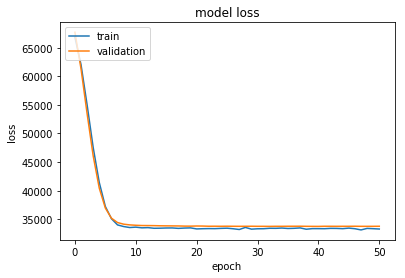

In [148]:
# Plot results
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()